# Modelos Ridge, Lasso y LogisticRegression

# Importar Librerías

Se importan las librerías esenciales para facilitar el análisis que abarca la carga de datos, la evaluación estadística, la visualización, la transformación de datos, la fusión y la unión.

In [1]:
#pip install kagglehub

In [2]:
import warnings
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import kagglehub
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from scipy.stats import kruskal
from scipy.stats import spearmanr
warnings.filterwarnings("ignore")

C:\Users\USER\miniconda3\envs\ml_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Lectura de Datos

Para la carga inicial del dataset, se utilizó la API de Kaggle Hub mediante Python, permitiendo una descarga automatizada y eficiente de los datos más recientes. El proceso consistió en:

1. **Descarga del Dataset**: Se obtuvo la versión actualizada del dataset 'Craigslist CarsTrucks Data' directamente desde Kaggle, almacenándose localmente en una ruta específica del sistema.

2. **Verificación de Archivos**: Se listaron los archivos descargados para confirmar la presencia del archivo principal (`vehicles.csv`).

3. **Carga en DataFrame**: El archivo CSV se leyó utilizando Pandas, asegurando una estructura lista para el análisis posterior.


In [3]:
path = kagglehub.dataset_download("austinreese/craigslist-carstrucks-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\USER\.cache\kagglehub\datasets\austinreese\craigslist-carstrucks-data\versions\10


In [4]:
downloaded_files = os.listdir(path)

print("Archivos disponibles:", downloaded_files)

Archivos disponibles: ['vehicles.csv']


In [5]:
csv_path = os.path.join(path, "vehicles.csv") 

df = pd.read_csv(csv_path)

---

Se emplea el método `df.info()` para evaluar la estructura y calidad inicial del dataset. Este análisis revela información sobre la composición de los datos, incluyendo el número total de registros (filas) y variables (columnas), los tipos de datos asociados a cada campo (como objetos, enteros o valores flotantes), y la cantidad de valores no nulos por columna.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

**Interpretación del Dataset**

1. **Volumen y Dimensiones**:

    - El conjunto de datos contiene 426,880 registros (filas) y 26 variables (columnas), lo que representa un volumen considerable de información sobre vehículos.

2. **Tipos de Datos**:

    - Predominan variables categóricas/cualitativas (19 columnas tipo object).

    - Variables numéricas incluyen 4 columnas float64 (`year`, `odometer`, `lat`, `long`) y 2 int64 (`id` y `price`). La variable `county` es tomada como float64 pero la columna esta totalmente vacía.

    - La columna `posting_date` está como texto (object), requiriendo conversión a datetime.

El dataset presenta un volumen masivo (426,880 registros) con amplia dimensionalidad (26 variables), ofreciendo un amplio potencial para análisis multivariados. Sin embargo, existe un desequilibrio significativo en la composición de datos, con predominio de variables categóricas (19 columnas) sobre numéricas (7 columnas), lo que implica desafíos en el preprocesamiento para modelos predictivos. La combinación de tamaño sustancial y diversidad de variables proporciona una base sólida para análisis exhaustivos, aunque requiere transformaciones intensivas en el manejo de fechas y limpieza de columnas vacías para maximizar su utilidad analítica.

## Tratamiento de outliers en variables numéricas

Con el objetivo de mitigar la influencia de valores atípicos extremos en las variables numéricas odometer y year, se aplicará un procedimiento de limpieza basado en percentiles. En particular, se eliminarán aquellas observaciones cuyos valores superen el percentil 99 de cada variable, ya que estos pueden distorsionar los análisis estadísticos posteriores o afectar negativamente el desempeño de los modelos predictivos. Este enfoque permite conservar la mayor parte de la información útil del conjunto de datos, al tiempo que se controla el efecto de outliers que podrían no ser representativos del comportamiento general del mercado.

### Price

In [7]:
print(df['price'].describe().apply(lambda x: f"{x:,.2f}"))

count          426,880.00
mean            75,199.03
std         12,182,282.17
min                  0.00
25%              5,900.00
50%             13,950.00
75%             26,485.75
max      3,736,928,711.00
Name: price, dtype: object


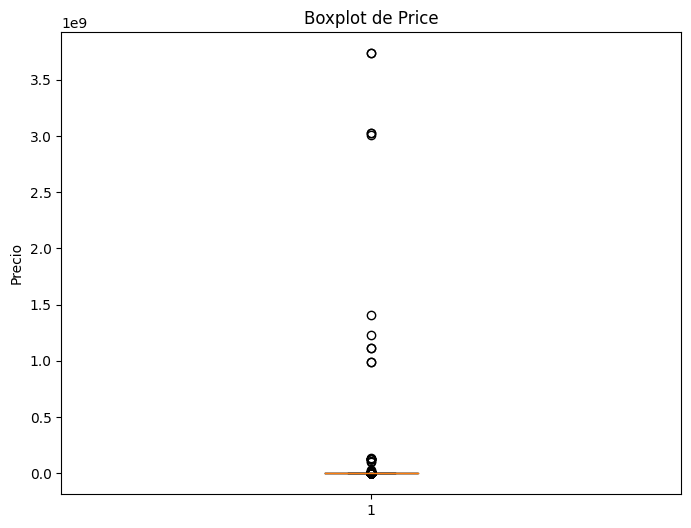

In [8]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['price'])
plt.title('Boxplot de Price')
plt.ylabel('Precio')
plt.show()

In [9]:
upper_bound = df['price'].quantile(0.99)

print(f"Límites: {upper_bound:,.2f}")

df = df[(df['price'] <= upper_bound)].copy()


Límites: 66,995.00


In [10]:
print(df['price'].describe().apply(lambda x: f"{x:,.2f}"))

count    422,615.00
mean      16,762.50
std       13,791.40
min            0.00
25%        5,899.00
50%       13,680.00
75%       25,990.00
max       66,995.00
Name: price, dtype: object


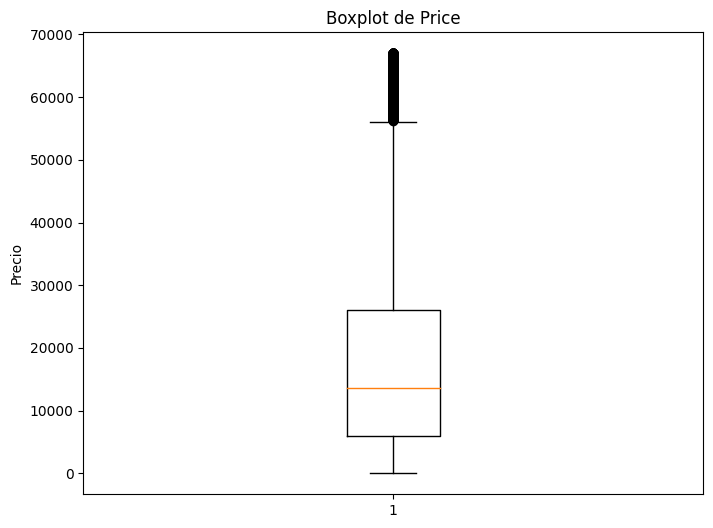

In [11]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['price'])
plt.title('Boxplot de Price')
plt.ylabel('Precio')
plt.show()

### Odometer

In [12]:
print(df['odometer'].describe().apply(lambda x: f"{x:,.2f}"))

count       418,261.00
mean         98,645.47
std         214,128.34
min               0.00
25%          38,670.00
50%          86,432.00
75%         134,000.00
max      10,000,000.00
Name: odometer, dtype: object


In [13]:
upper_bound = df['odometer'].quantile(0.99)

print(f"Límites: {upper_bound:,.2f}")

df = df[(df['odometer'] <= upper_bound)].copy()

print(f"Registros después de eliminar outliers: {len(df)}")

Límites: 279,984.40


Registros después de eliminar outliers: 414078


In [14]:
print(df['odometer'].describe().apply(lambda x: f"{x:,.2f}"))

count    414,078.00
mean      90,252.85
std       60,408.38
min            0.00
25%       38,130.00
50%       85,391.50
75%      132,172.00
max      279,974.00
Name: odometer, dtype: object


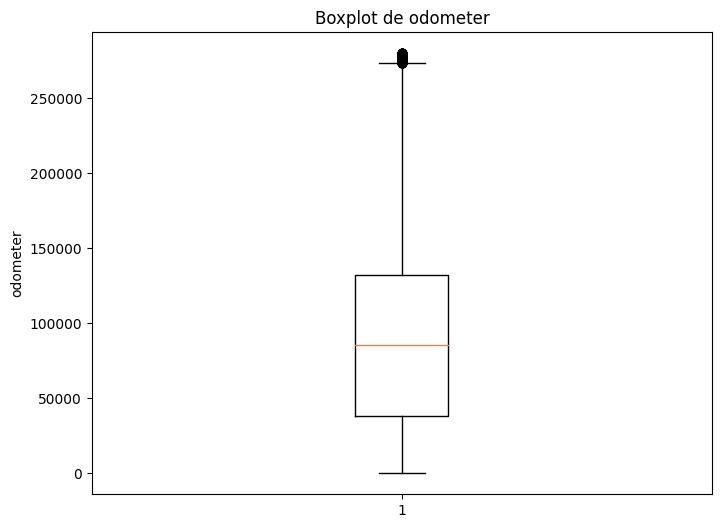

In [15]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['odometer'])
plt.title('Boxplot de odometer')
plt.ylabel('odometer')
plt.show()

## Valores Nulos

Para cuantificar la magnitud de datos ausentes en cada columna, se calculó el porcentaje de valores nulos mediante `df.isnull().mean() * 100`. Este indicador permite identificar variables críticas que requieren intervención prioritaria en el proceso de limpieza. Además, trabajaremos los valores de 0 en la variable precio como valores faltantes.

In [16]:
df['price'] = df['price'].replace(0, np.nan)
df.isnull().mean() * 100

id                0.000000
url               0.000000
region            0.000000
region_url        0.000000
price             7.377113
year              0.246330
manufacturer      3.854105
model             1.161858
condition        40.390699
cylinders        41.309608
fuel              0.565111
odometer          0.000000
title_status      1.807630
transmission      0.396302
VIN              37.409618
drive            30.534827
size             71.649303
type             21.551978
paint_color      30.249615
image_url         0.000000
description       0.000483
county          100.000000
state             0.000000
lat               1.557436
long              1.557436
posting_date      0.000000
dtype: float64

**Interpretación de Valores Nulos**

1. **Variables Completas (0% faltantes)**

    - `id` y `url` (0%): Son identificadores únicos del sistema. Su completitud del 100% indica que la base de datos mantiene integridad en su estructura fundamental. Esto es crítico para trazar cada registro individualmente.

    - `region` y `region_url` (0%): La ubicación geográfica principal está siempre registrada. Esto sugiere que el proceso de recolección valora y exige esta información, probablemente porque es esencial para el negocio o análisis de mercado regional.

    - `price` (0%): La variable objetivo principal está completa. Para un modelo de predicción de precios, esto es excelente. Indica que el precio no es opcional en los listados, lo cual tiene sentido comercialmente.

    - `state` (0%): Complementa la información regional, proporcionando contexto geográfico completo.

2. **Variables con Faltantes Leves (<5%)**

    - `year` (0.28%): Esto indica que el año del vehículo es considerado información casi obligatoria, probablemente porque afecta significativamente el valor.

    - `odometer` (1.03%): El kilometraje está casi completo.

    - `transmission` (0.60%) y `fuel` (0.71%): Características técnicas básicas están muy completas. Los faltantes mínimos sugieren que son campos casi obligatorios en el formulario.

3. **Variables con Faltantes Moderados (5-30%)**

    - `manufacturer` (4.13%): Aproximadamente en 4 de cada 100 vehículos no se registró la marca.

    - `model` (1.24%): Interesantemente, hay más marcas faltantes que modelos. 

    - `title_status` (1.93%): Esto indica que es información generalmente disponible pero no estrictamente obligatoria.

4.  **Variables con Faltantes Críticos (30-70%)**

    - `condition` (40.79%): Esto es alarmante porque la condición es crucial para la valoración. Sugiere que muchos vendedores omiten esta información o el campo no es obligatorio.

    - `cylinders` (41.62%): Casi la mitad de los vehículos no especifican cilindrada. Podría deberse a que muchos vendedores no conocen esta información técnica.

    - `VIN` (37.73%): Más de un tercio no tiene VIN. Esto es problemático para verificación de historial. Podría indicar vehículos más antiguos o vendedores que protegen privacidad.

    - `drive` (30.59%): Información técnica que muchos omiten.

    - `paint_color` (30.50%): Casi un tercio no especifica color.

5. **Variable con Faltantes Extremos (>70%)**

    - `size` (71.77%): Casi 3 de cada 4 vehículos no tienen tamaño especificado. Esto indica que este campo probablemente no existía en formularios antiguos o fue añadido posteriormente.

    - `county` (100%): Variable completamente inútil. Debe eliminarse inmediatamente. Su completa ausencia sugiere que era un campo planeado pero nunca implementado.

El análisis revela un dataset con integridad fundamental en variables críticas como precio, ubicación e identificadores, pero con debilidades significativas en atributos descriptivos como condición, cilindrada y características técnicas. La presencia masiva de valores faltantes en variables clave sugiere problemas estructurales en la recolección de datos más que errores aleatorios.


# Preprocesamiento

Este proceso incluye la limpieza de datos, que implica identificar y corregir errores e inconsistencias, así como la transformación de los datos para prepararlos para el análisis. Es esencial para garantizar que los datos estén listos para el modelado e interpretación, mejorando la calidad y precisión de los resultados. Para garantizar la calidad y manejabilidad del conjunto de datos, se tomaron las siguientes decisiones de limpieza inicial: eliminación de variables y eliminación de observaciones.

## Eliminación de Variables

Se descartaron las columnas `['county', 'id', 'url', 'region_url', 'VIN', 'image_url', 'description', 'long', 'lat', 'posting_date']` por las siguientes razones:

- `id`, `url`, `region_url`, `image_url`: Son identificadores o enlaces únicos que no aportan valor predictivo a un modelo de machine learning.

- `VIN`: El Vehicle Identification Number es un identificador que no aporta valor predictivo a un modelo de machine learning.

- `description`: Es un campo de texto libre. Su procesamiento requeriría técnicas de NLP (Procesamiento de Lenguaje Natural), lo cual no está contemplado en los objetivos de este análisis.

- `long` y `lat` (coordenadas geográficas): Si bien la ubicación es un factor crucial para el precio y la demanda, su tratamiento efectivo requiere de análisis geoespacial avanzado. Dado que el proyecto se centra en la aplicación de modelos de regresión lineal y logística, y para mantener un enfoque claro y reproducible, se decidió excluir estas variables, dejando su potencial análisis para un proyecto futuro.

- `posting_date`: La variable temporal es extremadamente valiosa para analizar tendencias y estacionalidad. Sin embargo, su incorporación adecuada requiere un feature engineering específico (como extraer el día de la semana, el mes, o si es fin de semana). Al igual que con las coordenadas, se optó por excluirla para priorizar el alcance definido, reconociendo su potencial para un análisis más profundo posterior.

- `county`: Variable completamente inútil ya que esta totalmente vacía.

In [17]:
df = df.drop(columns=['county', 'id', 'url', 'region_url', 'VIN', 'image_url', 'description', 'long', 'lat', 'posting_date'])

## Eliminación de Observaciones con Valores Faltantes (NA)

Se optó por eliminar todas las filas que contuvieran al menos un valor NA. Esta decisión se basó en dos factores clave:

- El proyecto sugiere un tamaño típico del conjunto de datos final entre 15.000 y 30.000 observaciones. El dataset original, con cientos de miles de entradas, permite esta reducción sin comprometer la capacidad de los modelos para generalizar.

- Un análisis preliminar reveló un alto porcentaje de valores nulos en varias columnas clave. Realizar una imputación robusta en tantas variables habría introducido un alto grado de incertidumbre y potencial sesgo en los datos, arriesgando la integridad del análisis. La eliminación garantiza la consistencia y calidad de los puntos de datos utilizados para el entrenamiento, resultando en un dataset más pequeño pero significativamente más limpio y confiable.

In [18]:
df = df.dropna() 

---

Se verifican los cambios realizados.

In [19]:
df.shape

(74362, 16)

## Valores únicos

Se calcula el número de valores únicos para cada variable del DataFrame.

In [20]:
df.nunique()

region            403
price            4050
year              101
manufacturer       41
model            9060
condition           6
cylinders           8
fuel                5
odometer        26216
title_status        6
transmission        3
drive               3
size                4
type               13
paint_color        12
state              51
dtype: int64

**Interpretación Valores únicos**

El análisis de cardinalidad de las variables categóricas y numéricas revela características fundamentales sobre la estructura y complejidad del dataset, cruciales para el diseño del pipeline de preprocesamiento. Se observa una cardinalidad extremadamente alta en la variable `model` (9,530 valores únicos), lo que presenta un desafío significativo para técnicas de codificación como One-Hot Encoding, ya que generaría una matriz de features excesivamente amplia y dispersa, incrementando la dimensionalidad y el riesgo de sobreajuste. La variable `manufacturer` (41 únicos) y `region` (403 únicos) también muestran una cardinalidad media-alta, manejable pero que requerirá una cuidadosa consideración. Por otro lado, variables como `transmission` (3), `fuel` (5), `title_status` (6), `drive` (3), y `condition` (6) exhiben una baja cardinalidad, lo que las hace ideales para ser codificadas sin mayor complicación. La presencia de 51 valores únicos en `state` confirma su uso como variable categórica geográfica. Para las variables numéricas, el alto número de valores únicos en `year`, `odometer`, y `price` es el comportamiento esperado y confirma su naturaleza continua, validando la decisión de escalarlas. Este perfil de cardinalidad sugiere la potencial necesidad de estrategias adicionales para variables como `model`, como agrupar modelos poco frecuentes en una categoría "Other" o utilizar técnicas de encoding alternativas, para garantizar la eficiencia y efectividad de los modelos de machine learning.

## Creación de la Variable Binaria "HighDemand"

Para la tarea de clasificación binaria especificada en los objetivos del proyecto, se creó la variable objetivo `HighDemand`.

In [21]:
df['HighDemand'] = (df['price'] > df['price'].median()).astype(int)

Se verifican los cambios realizados.

In [22]:
df.shape

(74362, 17)

## Separación de los conjutos X, y_reg, y_clf

In [23]:
categorical_cols = df.select_dtypes(include=['object']).columns

numeric_cols = ["year", "odometer"]

X = df[categorical_cols.tolist() + numeric_cols]

y_reg = df["price"]
y_clf = df["HighDemand"]

## Análisis de Correlación No Paramétrica para Variables Numéricas (Spearman)

Tras los resultados obtenidos en los análisis anteriores, se evidenció la necesidad de emplear métodos estadísticos robustos que no dependieran de supuestos restrictivos como la normalidad de los datos o la linealidad perfecta de las relaciones. Para evaluar la asociación entre las variables numéricas predictoras (year, odometer) y la variable objetivo price, se utilizó el coeficiente de correlación de Spearman.

A diferencia del coeficiente de Pearson, que mide únicamente la relación lineal, el coeficiente de Spearman evalúa relaciones monótonas (ya sean lineales o no lineales, siempre que la tendencia sea constante). Además, al basarse en los rangos de los datos en lugar de sus valores brutos, es mucho menos sensible a outliers, lo que lo hace ideal para analizar variables como el precio, que suelen presentar valores extremos y distribuciones sesgadas.


In [24]:
resultados = {}

for col in numeric_cols:
    corr, p = spearmanr(X[col], y_reg)
    resultados[col] = {"Corr": corr, "p_value": p}

spearman_df = pd.DataFrame(resultados).T.sort_values("Corr", ascending=False)

spearman_df

,Corr,p_value
year,0.535153,0.0
odometer,-0.460547,0.0


## Agrupamiento de Variables Categóricas de Alta Cardinalidad

En el análisis de datos, las variables categóricas con un gran número de categorías o niveles —conocidas como variables de alta cardinalidad— representan un desafío importante. Estas variables pueden dificultar la construcción de modelos debido al exceso de niveles poco representativos, la presencia de categorías con muy baja frecuencia y el aumento de la dimensionalidad al aplicar técnicas de codificación. Para superar este problema, una estrategia común es el agrupamiento de categorías, que consiste en combinar o reducir los niveles de la variable de manera que se conserven patrones relevantes y se minimice la pérdida de información. Este proceso permite simplificar la estructura de los datos, mejorar la eficiencia de los algoritmos de modelado y, en muchos casos, aumentar la capacidad predictiva de los modelos al evitar el sobreajuste.

### Preservación Selectiva de Modelos por Frecuencia 

Para abordar el desafío más crítico de cardinalidad en el dataset la variable `model` con 9,530 categorías únicas se implementó una  metodología consistió en mantener los modelos con una frecuencua mayor a 5 observaciones, las demás instanscias serán recategorizadas como `"other"`.

**Cardinalidad extrema:** La variable representaba el mayor riesgo de sobreajuste por dimensionalidad, haciendo esencial una reducción drástica pero inteligente.

**Impacto obtenido:** Esta intervención redujo la cardinalidad a un número manejable, transformando una variable inutilizable en una característica viable para el modelado predictivo.

---

**Alternativa Considerada: Eliminación Pura de la Variable**

Se evaluó la opción más conservadora de eliminar completamente la variable del modelo:

**Criterio propuesto:** "Eliminar la variable `model` y confiar en que las demás características (`manufacturer`, `type`, `year`, etc.) capturen suficiente varianza explicativa."

**Ventajas de la alternativa:**
- Eliminación completa del problema de cardinalidad
- Simplificación radical del pipeline de preprocesamiento
- Reducción del riesgo de sobreajuste por variables correlacionadas

**Limitaciones que motivaron su descarte:**
- Pérdida irreversible de información valiosa sobre modelos específicos que afectan significativamente el precio
- Incapacidad para capturar el efecto de modelos icónicos dentro de una marca
- Reducción potencial del poder predictivo del modelo

**Decisión final:** Se optó por la estrategia de agrupamiento para transformar una variable problemática en un recurso valioso. Este enfoque demuestra cómo el conocimiento del dominio automotriz (reconocer que la importancia de un modelo depende de su marca) puede informar técnicamente las decisiones de preprocesamiento. La solución implementada representa el balance ideal entre sofisticación técnica y pragmatismo aplicado.


In [25]:
umbral = 5

modelos_a_agrupar = df['model'].value_counts()[df['model'].value_counts() < umbral].index.tolist()

X['model'] = X['model'].apply(lambda x: 'other' if x in modelos_a_agrupar else x)

In [26]:
X.nunique()

region            403
manufacturer       41
model            2080
condition           6
cylinders           8
fuel                5
title_status        6
transmission        3
drive               3
size                4
type               13
paint_color        12
state              51
year              101
odometer        26216
dtype: int64

Se muestran las primeras filas del DataFrame con todos los detalles.  
Se usa `.to_string()` para evitar el truncamiento de columnas y lograr mostrar todas las variables.

In [27]:
print(X.head().to_string())

    region manufacturer            model  condition    cylinders    fuel title_status transmission drive       size      type paint_color state    year  odometer
31  auburn         ford        f-150 xlt  excellent  6 cylinders     gas        clean    automatic   rwd  full-size     truck       black    al  2013.0  128000.0
55  auburn         ford  f250 super duty       good  8 cylinders  diesel        clean    automatic   4wd  full-size    pickup        blue    al  2004.0   88000.0
59  auburn        honda          odyssey  excellent  6 cylinders     gas        clean    automatic   fwd  full-size  mini-van      silver    al  2012.0   95000.0
65  auburn         ford             f450       good  8 cylinders  diesel        clean       manual   rwd  full-size     truck       white    al  2001.0  144700.0
73  auburn        dodge            other  excellent  8 cylinders     gas      rebuilt    automatic   rwd   mid-size     sedan        grey    al  2017.0   90000.0



Se muestran las últimas filas del DataFrame con todos los detalles.  
Se usa `.to_string()` para evitar el truncamiento de columnas y lograr mostrar todas las variables.

In [28]:
print(X.tail().to_string())

         region manufacturer                    model  condition    cylinders fuel title_status transmission drive         size         type paint_color state    year  odometer
426793  wyoming    chevrolet                cruze, lt  excellent  4 cylinders  gas        clean    automatic   fwd     mid-size        sedan       black    wy  2018.0   36465.0
426808  wyoming    chevrolet    silverado 1500 lt 4x4  excellent  8 cylinders  gas         lien    automatic   4wd    full-size        truck        blue    wy  2005.0  130000.0
426809  wyoming         jeep                    other       good  8 cylinders  gas        clean    automatic   4wd    full-size          SUV       black    wy  1990.0  114400.0
426831  wyoming       nissan  300zx coupe with t-tops   like new  6 cylinders  gas        clean    automatic   rwd  sub-compact    hatchback         red    wy  1985.0  115000.0
426833  wyoming       jaguar          xk8 convertible       good  8 cylinders  gas        clean    automatic   rwd 

## Análisis de Relevancia de Variables Categóricas (Prueba de Kruskal-Wallis)

Kruskall-Wallis es la alternativa no paramétrica al ANOVA de una vía. No asume normalidad en los datos y es menos sensible a outliers, ya que trabaja con los rangos de los datos en lugar de sus valores absolutos. Evalúa la hipótesis nula de que las medianas de price son iguales entre todas las categorías de una variable.

- H₀: Las medianas del precio son iguales en todos los grupos.

- H₁: Al menos un grupo tiene una mediana del precio diferente.

El estadístico H obtenido indica la magnitud de la diferencia entre los grupos, donde un valor más alto sugiere una variable más relevante para predecir el precio.

In [29]:
categorical_cols = df.select_dtypes(include=['object']).columns

In [30]:
resultados = {}

for col in categorical_cols:
    grupos = [y_reg[X[col] == cat] for cat in X[col].unique()]
    
    if len(grupos) > 1:
        stat, p = kruskal(*grupos)
        resultados[col] = {"H": stat, "p_value": p}

kruskal_df = pd.DataFrame(resultados).T.sort_values("H", ascending=False)

print(kruskal_df)

                         H        p_value
model         29076.876775   0.000000e+00
type          13870.815801   0.000000e+00
drive          9657.959249   0.000000e+00
condition      8628.766865   0.000000e+00
manufacturer   7686.684655   0.000000e+00
region         6818.696503   0.000000e+00
cylinders      6241.293779   0.000000e+00
fuel           5419.093383   0.000000e+00
size           4797.823188   0.000000e+00
paint_color    3180.962528   0.000000e+00
state          3074.011575   0.000000e+00
title_status    717.458397  8.245503e-153
transmission    654.636701  7.037956e-143


## Selección de Variables Basada en Relevancia Predictiva y Manejo de Categoricas

Como parte del proceso de optimización del modelo y con el objetivo de maximizar su poder predictivo, se llevó a cabo una evaluación exhaustiva de la contribución individual de cada variable mediante análisis estadístico no paramétrico (prueba de Kruskal-Wallis). Este análisis permitió cuantificar la capacidad de cada característica para discriminar entre los diferentes rangos de precio en el conjunto de datos.

Contrario a un enfoque de eliminación, el análisis reveló que todas las variables consideradas mostraron un grado de relevancia estadística en la explicación de la variabilidad del precio. Si bien se identificaron diferencias en la magnitud del estadístico H entre variables, cada una aporta información valiosa y única al modelo.

In [31]:
categorical_cols = X.select_dtypes(include=['object']).columns
categorical_cols

Index(['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color',
       'state'],
      dtype='object')

## Configuración de la Búsqueda de Hiperparámetros con GridSearchCV

Para optimizar el rendimiento de los modelos de manera eficiente y encontrar el valor óptimo de los hiperparámetros de regularización, se utilizaron los métodos de validación cruzada integrados en scikit-learn: `RidgeCV`, `LassoCV` y `LogisticRegressionCV`. Estos algoritmos realizan una búsqueda automatizada del mejor hiperparámetro mediante validación cruzada integrada, ofreciendo una implementación más optimizada y computacionalmente eficiente que una configuración manual de GridSearchCV.

Estrategia de Implementación:

`RidgeCV` y `LassoCV`: Realizan una búsqueda sobre un rango predefinido de valores de alpha (fuerza de regularización) mediante validación cruzada, seleccionando automáticamente el valor que minimiza el error cuadrático medio.

`LogisticRegressionCV`: Realiza una búsqueda similar para el parámetro C (inversa de la fuerza de regularización) utilizando validación cruzada estratificada, crucial para mantener la proporción de clases en cada fold en problemas de clasificación.

Los hiperparámetros a optimizar son:

- `alpha` para Ridge y Lasso, que controla la fuerza de la regularización.

- `C` para Regresión Logística, que controla la inversa de la fuerza de la regularización.

## Prepocesamiento variables categóricas y numéricas

La configuración del preprocesador especifica dos transformaciones en paralelo:

1. **Escalado estandarizado** para variables numéricas continuas.

2. **Codificación one-hot** con eliminación de la primera categoría para evitar multicolinealidad en las variables categóricas.

In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler


scaler = StandardScaler()
X_num = scaler.fit_transform(X[numeric_cols])

ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
X_cat = ohe.fit_transform(X[categorical_cols])

X = np.hstack([X_num, X_cat])

## Creación de Conjuntos de Entrenamiento y Prueba

Para evaluar de manera rigurosa y justa el desempeño final de los modelos optimizados, es esencial probarlos en datos que no hayan sido vistos durante el proceso de ajuste de hiperparámetros. Por esta razón, se divide el dataset en subconjuntos de entrenamiento y prueba. El conjunto de entrenamiento (`X_train`, `y_train`) se utilizará para reentrenar el mejor modelo encontrado por `GridSearchCV` con todos los datos disponibles de entrenamiento, mientras que el conjunto de prueba (`X_test`, `y_test`) se reservará exclusivamente para la evaluación final, proporcionando una estimación no sesgada del rendimiento del modelo en datos nuevos.

La división se realiza dos veces de manera independiente:

1. Para la tarea de Regresión: Se divide las features (`X`) y la variable objetivo continua (`y_reg`).

2. Para la tarea de Clasificación: Se divide las features (`X`) y la variable objetivo binaria (`y_clf`), utilizando el parámetro `stratify` para garantizar que la proporción de las clases `HighDemand` se mantenga igual en ambos conjuntos, preservando así el balance original.

Un 20% de los datos se asigna para prueba en ambos casos, utilizando una semilla (`random_state=42`) para asegurar la reproducibilidad de la partición.

In [33]:

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, stratify=y_clf, random_state=42
)

## Ejecución de la Búsqueda de Hiperparámetros y Entrenamiento de los Modelos

Una vez configuradas las estrategias de búsqueda, se procede a ejecutar el entrenamiento de los modelos. Este paso es donde se implementa de manera práctica el flujo completo de machine learning definido teóricamente. El método `fit()` de cada objeto no solo entrena el modelo final con la mejor combinación de hiperparámetros encontrada, sino que realiza de manera automatizada y segura todo el proceso de validación cruzada, preprocesamiento y optimización.

Los hiperparámetros a optimizar son:

- `alpha` para Ridge y Lasso, que controla la fuerza de la regularización.

- `C` para Regresión Logística, que controla la inversa de la fuerza de la regularización.

### Ridge

In [34]:
from sklearn.linear_model import RidgeCV

alphas = [0.01, 0.1, 1, 10, 100]
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train_reg, y_train_reg)

best_alpha = ridge_cv.alpha_
print("--- Resultados RidgeCV ---")
print("Mejor alpha:", best_alpha)

KeyboardInterrupt: 

### Lasso

In [82]:
from sklearn.linear_model import LassoCV

alphas = [0.01, 0.1, 1, 10, 100]
lasso_cv = LassoCV(alphas=alphas, cv=5, n_jobs=-1, max_iter=1000)

lasso_cv.fit(X_train_reg, y_train_reg)

best_alpha = lasso_cv.alpha_
print("--- Resultados LassoCV ---")
print("Mejor alpha:", best_alpha)

--- Resultados LassoCV ---
Mejor alpha: 0.1


### Regresión Logística

In [83]:
from sklearn.linear_model import LogisticRegressionCV
C = [0.01, 0.1, 1, 10, 100]

logreg_cv = LogisticRegressionCV(Cs=C,cv=5,penalty="l2",solver="liblinear",max_iter=1000,n_jobs=-1,scoring="roc_auc")

logreg_cv.fit(X_train_clf, y_train_clf)

best_C = logreg_cv.C_[0]
print("\n--- Resultados LogisticRegressionCV ---")
print("Mejor C:", best_C)


--- Resultados LogisticRegressionCV ---
Mejor C: 10.0


## Análisis de los Resultados de la Búsqueda de Hiperparámetros

Tras completar el proceso de búsqueda exhaustiva, se extraen y analizan los resultados óptimos para cada modelo. Esta etapa es crucial para identificar la configuración de hiperparámetros que maximiza el rendimiento de cada algoritmo según la métrica de evaluación definida. Los resultados se presentan mostrando la mejor combinación de parámetros encontrada y su score de validación cruzada correspondiente.

Es importante notar que para los modelos de regresión (Ridge y Lasso), el score reportado por `GridSearchCV` es el negative mean squared error (`neg_mean_squared_error`). Por convención de scikit-learn, este valor se negativiza para que el algoritmo de optimización siempre busque maximizar el score. Por lo tanto, para interpretar el resultado en la escala original del Error Cuadrático Medio (MSE), es necesario multiplicar el valor por -1, obteniendo así el MSE promedio en la validación cruzada. Para el modelo de clasificación (Regresión Logística), el score de precisión (accuracy) se reporta directamente en su escala interpretable.

# Evaluación de desempeño

La evaluación de desempeño es una etapa fundamental en el desarrollo de modelos de machine learning, ya que permite medir qué tan bien se ajusta el modelo a los datos y, sobre todo, qué capacidad tiene para generalizar en situaciones no vistas. A través de métricas específicas (que varían según si se trata de un problema de regresión o de clasificación) es posible identificar fortalezas y debilidades del modelo, así como comparar diferentes enfoques y versiones durante el proceso de experimentación. Además de las métricas numéricas, las visualizaciones como matrices de confusión, curvas ROC o gráficos de predicciones frente a valores reales ofrecen una perspectiva más clara sobre el rendimiento alcanzado. De esta manera, la evaluación del desempeño no solo valida la efectividad del modelo, sino que también orienta la toma de decisiones para su mejora continua.


--- Evaluación Ridge (Test) ---
MAE: 4301.411473216919
RMSE: 6357.318009836137
R²: 0.6829187266031913


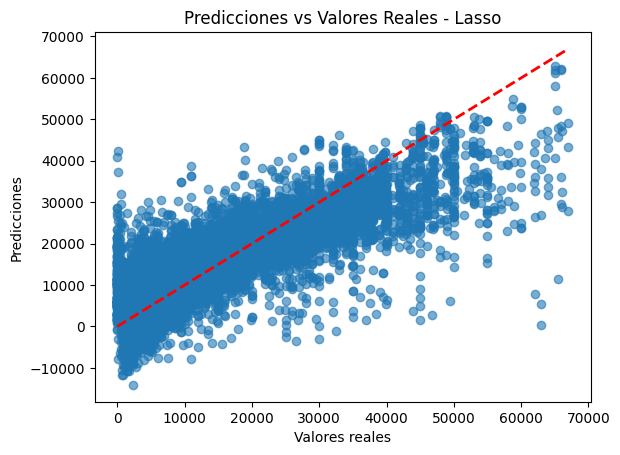


--- Evaluación Ridge (Test) ---
MAE: 4293.697246841724
RMSE: 6358.30376795713
R²: 0.6828203864941097


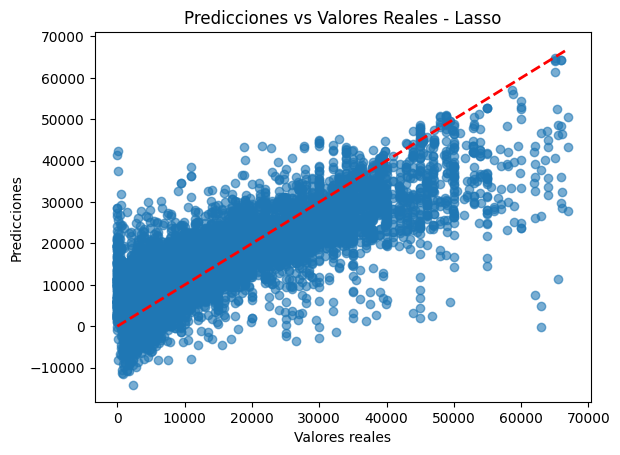

In [84]:

#Gráfica Ridge

y_pred_ridge = ridge_cv.predict(X_test_reg)

print("\n--- Evaluación Ridge (Test) ---")
print("MAE:", mean_absolute_error(y_test_reg, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_ridge)))
print("R²:", r2_score(y_test_reg, y_pred_ridge))

plt.scatter(y_test_reg, y_pred_ridge, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()],
         'r--', lw=2)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales - Lasso")
plt.show()


#Gráfica Lasso


y_pred_lasso = lasso_cv.predict(X_test_reg)

print("\n--- Evaluación Ridge (Test) ---")
print("MAE:", mean_absolute_error(y_test_reg, y_pred_lasso))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_lasso)))
print("R²:", r2_score(y_test_reg, y_pred_lasso))

plt.scatter(y_test_reg, y_pred_lasso, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()],
         'r--', lw=2)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales - Lasso")
plt.show()

### Ridge

El modelo Ridge logra explicar aproximadamente el 68.2% (R² = 0.682) de la variabilidad de la variable objetivo. Esto indica un poder predictivo moderado, donde poco más de la mitad de los cambios en la variable dependiente pueden ser explicados por las variables independientes incluidas en el modelo.

En términos de error, el modelo comete, en promedio, un error de $4301 (MAE) en sus predicciones. El RMSE, que penaliza más los errores grandes, es de $6357. Esto sugiere que, si bien el error promedio es de alrededor de cinco mil unidades, existen algunas predicciones con errores considerablemente más grandes que elevan esta métrica.

El gráfico muestra que los puntos comienzan a dispersarse notablemente conforme los valores reales aumentan (especialmente después de las 60000 unidades). Esta dispersión más ancha confirma la existencia de errores de predicción mayores para valores altos. En conclusión el modelo presenta un desempeño aceptable pero con margen de mejora. Es útil para obtener una aproximación general, pero sus predicciones para valores altos, deben ser tomadas con cautela debido a su error considerable.

### Lasso

Se observa que el desempeño del modelo Lasso es casi idéntico al del modelo Ridge. Explica el 68.2% de la variabilidad de los datos, lo que representa una mejora insignificante de apenas 0.4 puntos porcentuales respecto al modelo Ridge.

Sus métricas de error son prácticamente iguales: un MAE de $4293 vs. $4301 de Ridge y un RMSE de $6358 vs. $6357.

El gráfico de dispersión para Lasso sería virtualmente indistinguible del de Ridge, mostrando el mismo patrón de dispersión y los mismos problemas para predecir valores altos con precisión. Se puede concluir que el modelo Lasso no ofrece una ventaja real sobre el modelo Ridge para este conjunto de datos en particular. Ambos modelos tienen el mismo poder explicativo y cometen errores de magnitud similar.

## Evaluación Final del Modelo de Clasificación en el Conjunto de Prueba

Para completar el análisis del objetivo de clasificación binaria, se evaluó el desempeño del mejor modelo de Regresión Logística identificado mediante `GridSearchCV` en el conjunto de prueba reservado para esta tarea. La evaluación de un modelo de clasificación requiere un análisis más multidimensional que la regresión, ya que es necesario considerar no solo la capacidad de predicción general (accuracy) sino también el equilibrio entre los diferentes tipos de error (falsos positivos y falsos negativos), lo cual es crucial dependiendo del contexto de aplicación.

El modelo se reentrenó con la totalidad del conjunto de entrenamiento de clasificación (`X_train_clf`, `y_train_clf`) y se generaron tanto predicciones de clase (`predict`) como probabilidades (`predict_proba`) para el conjunto de prueba. El desempeño se evaluó mediante un conjunto exhaustivo de métricas y visualizaciones:

- **Métricas de Evaluación**:

    - **Accuracy**: Proporción general de predicciones correctas.

    - **Precision**: Capacidad del modelo de no etiquetar como de alta demanda a un vehículo que no lo es (evitar falsos positivos).

    - **Recall**: Capacidad del modelo de encontrar todos los vehículos de alta demanda (evitar falsos negativos).

    - **F1-score**: Media armónica entre Precision y Recall, ideal para conjuntos balanceados.

- **Visualizaciones**:

    - **Matriz de Confusión**: Muestra de forma explícita los aciertos (diagonal) y los errores (falsos positivos y falsos negativos) del modelo.

    - **Curva ROC y AUC**: Evalúa la capacidad del modelo para distinguir entre clases a través de todos los posibles umbrales de clasificación. Un AUC de 0.5 representa un modelo aleatorio, mientras que 1.0 representa una separación perfecta.

Evaluación Logistic Regression
Accuracy: 0.8542997377798696
Precision: 0.8604332327940774
Recall: 0.8452525252525253
F1-score: 0.8527753244106258


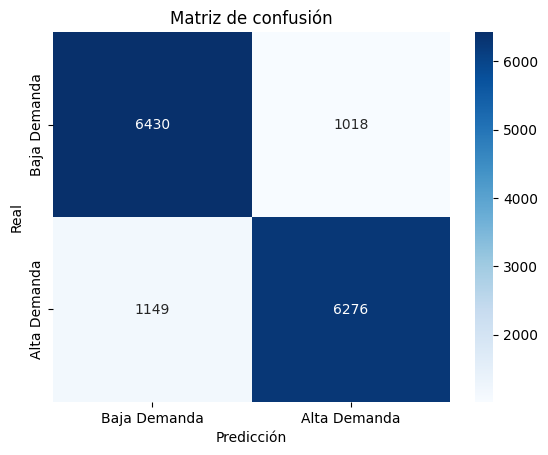

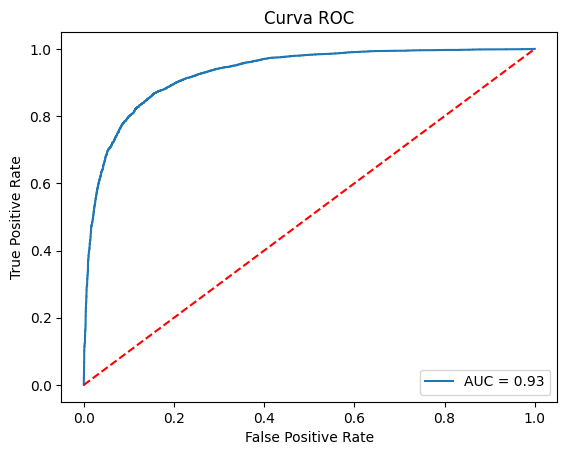

In [85]:
y_pred_clf = logreg_cv.predict(X_test_clf)
y_pred_proba = logreg_cv.predict_proba(X_test_clf)[:,1]

acc = accuracy_score(y_test_clf, y_pred_clf)
prec = precision_score(y_test_clf, y_pred_clf)
rec = recall_score(y_test_clf, y_pred_clf)
f1 = f1_score(y_test_clf, y_pred_clf)

print("Evaluación Logistic Regression")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)

cm = confusion_matrix(y_test_clf, y_pred_clf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Baja Demanda","Alta Demanda"], yticklabels=["Baja Demanda","Alta Demanda"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión")
plt.show()

fpr, tpr, _ = roc_curve(y_test_clf, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()



### Regresión logística
El modelo de Regresión Logística muestra un desempeño sobresaliente en la clasificación de la demanda, con valores altos y balanceados en precisión, recall y F1-score, además de un AUC de 0.93 que confirma su fuerte capacidad de discriminación.

En términos prácticos, el modelo es confiable tanto para identificar correctamente la alta demanda como para evitar sobreestimaciones, lo cual lo hace útil en contextos de planificación de recursos o gestión operativa. Los errores (falsos positivos y falsos negativos) existen, pero están en proporciones manejables frente al número total de aciertos.